In [1]:
import numpy as np
import pandas as pd
import math
import random

class Isotope:
    def __init__(self, name, half_life, decay_modes, count=0, is_stable=False):

        self.name = name
        self.half_life = half_life
        self.decay_modes = decay_modes
        self.count = count
        self.is_stable = is_stable

    def decay(self):
        if self.is_stable or not self.decay_modes:
            return ("stable", self.name)

        r = random.random()
        cumulative = 0.0
        for mode, daughter, prob in self.decay_modes:
            cumulative += prob
            if r < cumulative:
                return (mode, daughter)
        # Fallback in case of rounding errors
        return self.decay_modes[-1]

    def time_until_decay(self):
        return random.expovariate(math.log(2) / self.half_life)


In [2]:
decay_data = {
    "Ra_228": {
        "half_life": 5.7 * 365 * 24 * 3600,
        "decay_modes": [("beta", "Ac_228", 1.0)]
    },
    "Ac_228": {
        "half_life": 6.1 * 60,
        "decay_modes": [("beta", "Th_228", 1.0)]
    },
    "Th_228": {
        "half_life": 1.9 * 365 * 24 * 3600,
        "decay_modes": [("alpha", "Ra_224", 1.0)]
    },
    "Ra_224": {
        "half_life": 3.6 * 24 * 3600,
        "decay_modes": [("alpha", "Rn_220", 1.0)]
    },
    "Rn_220": {
        "half_life": 55,
        "decay_modes": [("alpha", "Po_216", 1.0)]
    },
    "Po_216":{
        "half_life":  0.14,
        "decay_modes": [("alpha", "Pb_212", 1.0)]
    },
    "Pb_212":{
        "half_life":  10.6 * 3600,
        "decay_modes": [("beta", "Bi_212", 1.0)]
    },
    "Bi_212":{
        "half_life":  61 * 60,
        "decay_modes": [("beta", "Po_212", 0.6406),
                        ("alpha", "Tl_208", 0.3594)]
    },
    "Po_212":{
        "half_life":  3e-7,
        "decay_modes": [("alpha","Pb_208", 1.0)]
    },
    "Tl_208":{
        "half_life": 3.1 * 60,
        "decay_modes": [("beta", "Pb_208", 1.0)]}
    # Pb 208 is stable define separately
}

Th_232 = Isotope("Th_232", 1.41e10 * 365 * 24 * 3600, [("alpha", "Ra_228", 1.0)], 999)
# Build Isotope objects
Pb_208 = Isotope("Pb_208", float('inf'), [], is_stable=True)

isotopes = {}
for name, data in decay_data.items():
    isotopes[name] = Isotope(name, data["half_life"], data["decay_modes"])
    
# List of Isotope instances
isotope_list = [Th_232] + list(isotopes.values()) + [Pb_208]
lambda_list = []

for i in isotope_list:
    lambda_list.append(math.log(2)/i.half_life)
    


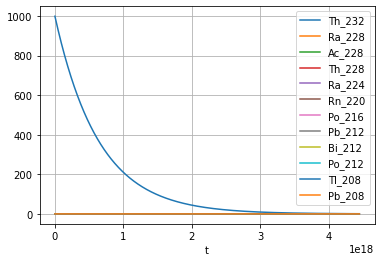

In [13]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

name_to_index = {iso.name: idx for idx, iso in enumerate(isotope_list)}


#Initial Counts
y0=[]
for i in isotope_list:
    y0.append(i.count)


# 

def returns_dydt(y, t):
    dydt = [0.0] * len(isotope_list)
    branching_ratios=[]

    for i, isotope in enumerate(isotope_list):
        lambda_i = math.log(2) / isotope.half_life
        for j, parent in enumerate(isotope_list):
            for mode, daughter_name, br in parent.decay_modes:
                if daughter_name == isotope.name:
                    lambda_j = math.log(2) / parent.half_life
                    branching_ratios.append(br)
                else:
                    branching_ratios.append(0)
            dydt[i]+=branching_ratios[j]*(math.log(2)/parent.half_life)*y[j]
            
            

        
        dydt[i] -= lambda_i * y[i]

       

    return dydt


#set initial condition
t_max = 10 * Th_232.half_life
t_points = 99999 
t = np.linspace(0, t_max, t_points)
# solving ODE
sol_y = odeint(returns_dydt, y0, t)

# plot results ignore for now
import matplotlib.pyplot as plt
for i, isotope in enumerate(isotope_list):
    plt.plot(t, sol_y[:, i], label=isotope.name)
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()


